In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
from torchcrf import CRF
from tqdm import tqdm
from tabulate import tabulate
import unicodedata
from math import floor
import numpy as np

# Parte 1 - Criando o dataset

In [2]:
class segmentation_dataset(Dataset):
    def __init__(self, tag2idx, word2idx, set_type):
        """
        Load the segmentation dataset, (self.__load__())
        Truncate long sentences/split long blocks/ignore very short blocks (self.__trunc__())
        get indices of words and tags (self.__get_idx__())
        PAD the sentences and blocks/create MASKS representing padded elements (self.__pad__())
        """
        self.set_type = set_type
        self.min_block_length = 3
        self.max_sentence_length = 30
        self.max_block_length = 20
        
        self.__load__()
        self.__trunc__()
        self.__split__()
        self.__get_idx__(tag2idx, word2idx)
        self.__pad__()
        
        self.x = torch.LongTensor(self.x)
        self.y = torch.LongTensor(self.y)
        self.mask = torch.ByteTensor(self.mask)
        
    def __getitem__(self, index):
        """
        Get one item from the dataset
        """
        return self.x[index], self.mask[index], self.y[index]
    
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.x)
    
    def __load__(self):
        """
        Load raw dataset from seg_data.txt
        """
        data = open('seg_data.txt', 'r').read().splitlines()
        x = []
        y = []
        temp_x = []
        temp_y = []
        for line in data:
            if not line:
                if len(temp_x)>0:
                    x.append(temp_x)
                    y.append(temp_y)
                temp_x = []
                temp_y = []
            else:
                if len(line.split())>=2:
                    temp_x.append(line[1:].split())
                    temp_y.append(line[0])
        if temp_x:
            x.append(temp_x)
            y.append(temp_y)
        
        self.x = x
        self.y = y
        
    def __trunc__(self):
        """
        Truncate sentences with length > max_sentence_length
        Separate blocks with length > max_block_length
        Delete blocks with length < min_block_length
        """
        # For each block in x
        for i in range(len(self.x)):
            # For each sentence in x[i]
            for j in range(len(self.x[i])):
                if len(self.x[i][j]) > self.max_sentence_length:
                    self.x[i][j] = self.x[i][j][:self.max_sentence_length]

        sep_x = []
        sep_y = []
        for i in range(len(self.x)):
            if len(self.x[i]) > self.max_block_length:
                for j in range((len(self.x[i])//self.max_block_length)+1):
                    if self.x[i][j*self.max_block_length:(j+1)*self.max_block_length]:# and 'B' in self.y[i]:
                        sep_x.append(self.x[i][j*self.max_block_length:(j+1)*self.max_block_length])
                        sep_y.append(self.y[i][j*self.max_block_length:(j+1)*self.max_block_length])
            elif len(self.x[i]) < self.min_block_length:
                continue
#             elif 'B' in self.y[i]:
            else:
                sep_x.append(self.x[i])
                sep_y.append(self.y[i])
        self.x = sep_x
        self.y = sep_y
        
    def __split__(self):
        train_split = floor(0.6*len(self.x))
        valid_split = floor(0.1*len(self.x)) + train_split 
        if self.set_type == 'train':
            print("Treinamento")
            self.x = self.x[:train_split]
            self.y = self.y[:train_split]
        elif self.set_type == 'valid':
            print("validacao")
            self.x = self.x[train_split:valid_split]
            self.y = self.y[train_split:valid_split]
        else:
            print("teste")
            self.x = self.x[valid_split:]
            self.y = self.y[valid_split:]
        
    def __get_idx__(self, tag2idx, word2idx):
        """
        Convert words (x) into indices for the embedding layer
        PADs sentences to self.max_sentence_length
        Convert tags (y) into indices 
        """
        # get_idx of x
        for i in range(len(self.x)):
            for j in range(len(self.x[i])):
                for k in range(len(self.x[i][j])):
                    w = self.x[i][j][k].replace(',', '').replace(';', '').replace(':', '').lower()
                    if w in word2idx:
                        self.x[i][j][k] = word2idx[w]
                    else:
                        self.x[i][j][k] = 0
                while(len(self.x[i][j]) < self.max_sentence_length):
                    self.x[i][j].append(0)
                
        # get_idx of y      
        for i in range(len(self.y)):
            for j in range(len(self.y[i])):
                self.y[i][j] = tag2idx[self.y[i][j]]
                
    def __pad__(self):
        """
        Pad blocks of sentences to self.max_block_length
        Creates MASKS to indicate padded sentences in each block
        """
        self.mask = []
        sent_padder = [0 for i in range(self.max_sentence_length)]
        for i in range(len(self.x)):
            temp_mask = [0 for i in range(self.max_block_length)]
            for j in range(len(self.x[i])):
                temp_mask[j] = 1
            self.mask.append(temp_mask)
            while len(self.x[i]) < self.max_block_length:
                self.x[i].append(sent_padder)
                self.y[i].append(-1)
                

In [3]:
emb = KeyedVectors.load_word2vec_format("embeddings/cbow_s50.txt")
dic = {}
for j in emb.wv.index2word:
    num = emb.vocab[j].index
    word = unicodedata.normalize('NFKD', j).encode('ascii', 'ignore').decode('utf8')
    dic[word] = emb.vocab[j].index
print(len(dic))

dic_tag = {'B': 0, 'I': 1, 'O': 2}
idx2tag = {0: 'B', 1:'I', 2:'O'}

<ipython-input-3-55cbd2721a19>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  for j in emb.wv.index2word:


866822


In [4]:
train_dataset = segmentation_dataset(tag2idx=dic_tag, word2idx=dic, set_type='train')
valid_dataset = segmentation_dataset(tag2idx=dic_tag, word2idx=dic, set_type='valid')
test_dataset = segmentation_dataset(tag2idx=dic_tag, word2idx=dic, set_type='test')
len(train_dataset.x), len(valid_dataset.x), len(test_dataset.x)

Treinamento
validacao
teste


(81139, 13523, 40571)

In [5]:
print("Numero de classes por conjunto de dados (treinamento, validacao e teste)")

# tags = {'B':0, 'I':0, 'O':0}
tags = [0, 0, 0]
for block in train_dataset.y:
    for tag in block:
        tags[tag] += 1
print("Conjunto de treinamento:", tags)

# tags = {'B':0, 'I':0, 'O':0}
tags = [0, 0, 0]
for block in valid_dataset.y:
    for tag in block:
        tags[tag] += 1
print("Conjunto de validacao:", tags)

# tags = {'B':0, 'I':0, 'O':0}
tags = [0, 0, 0]
for block in test_dataset.y:
    for tag in block:
        tags[tag] += 1
print("Conjunto de teste:", tags)

Numero de classes por conjunto de dados (treinamento, validacao e teste)
Conjunto de treinamento: [3613, 10768, 1608399]
Conjunto de validacao: [518, 1464, 268478]
Conjunto de teste: [1251, 3875, 806294]


In [6]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader  = DataLoader(dataset = test_dataset , batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Parte 2 - Criando o modelo

In [7]:
class LSTM_CRF(nn.Module):
    def __init__(self, embedding_dim, num_tags, hidden_dim, pretrained_emb, idx2tag):
        super(LSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_tags = num_tags
        self.idx2tag_dict = idx2tag
        # Set device for training
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Defining all the nn layers
        self.embed_layer       = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_emb.vectors))
        self.embed_layer.weight[0] = 0
        self.word_LSTM_layer   = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.sent_LSTM_layer   = nn.LSTM(hidden_dim, hidden_dim//4, num_layers=1, batch_first=True)
        self.linear_layer      = nn.Linear(hidden_dim//4, num_tags)
        self.crf_layer         = CRF(num_tags, batch_first=True)

    def forward(self, batch_input, batch_tags, mask_pad):
        """
        Method to compute the forward pass of the LSTM_CRF model
        Input: (x) shape:        (batch_size) x (sequence_length) x (sentence_length)
               (y) shape:        (batch_size) x (sequence_length)
               (mask_pad) shape: (batch_size) x (sequence_length)
        output: log_likelihood  of the probability of the expected sequence of tags
        """
        batch_size = batch_input.shape[0]
        sequence_pad_size = batch_input.shape[1]
        sentence_pad_size = batch_input.shape[2]
        
        # Embedding Layer
        emb_out = self.embed_layer(batch_input)
        # Word level LSTM layer
        word_lstm_out, (hn, cn) = self.word_LSTM_layer(emb_out.view(batch_size*sequence_pad_size, sentence_pad_size, self.embedding_dim))
        # Sentence level LSTM layer
        sent_lstm_out, (hn, cn) = self.sent_LSTM_layer(hn.view(batch_size, sequence_pad_size, self.hidden_dim))
        # Linear (fully-connected) layer
        lin_out = self.linear_layer(sent_lstm_out.reshape(batch_size * sequence_pad_size, self.hidden_dim//4))
        # CRF layer
        return self.crf_layer(lin_out.view(batch_size, sequence_pad_size, self.num_tags), batch_tags)

    def fit(self, epoch, train_loader, eval_loader, **kwargs):
        """
        Method to train the LSTM_CRF model
        Input: (x) shape: (number of batches) x (batch_size) x (sequence_length) x (sentence_length)
               (y) shape: (number of batches) x (batch_size) x (sequence_length)
        output: validation_loss (validation loss over all epochs)
        """
        if 'lr' in kwargs:
            learning_rate = kwargs.get('lr')
        else:
            learning_rate = 0.01
            
        if 'weight_decay' in kwargs:
            wd = kwargs.get('weight_decay')
        else:
            wd = 1e-4
            
        validation_loss = []
        min_loss = float('inf')
#         optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, weight_decay=wd)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=wd)
        for it in range(epoch):
            print("Epoch:", it)
            for batch in tqdm(train_loader):
                x, mask, y = batch
                x = x.to(self.device)
                mask = mask.to(self.device)
                y = y.to(self.device)
                
                self.zero_grad()
                loss = -self.forward(x, y, mask)
                loss.backward()
                optimizer.step()
                
            new_loss = self.evaluate(eval_loader, opt='loss')
            if new_loss < min_loss:
                min_loss = new_loss
                torch.save(model.state_dict(), "normal_dataset/seg_model_256_50dim_adam")
            validation_loss.append(new_loss)
        return validation_loss
    
    def evaluate(self, valid_loader, opt):
        """
        Method to evaluate trained model on unseen data
        """
        if opt == 'loss':
            with torch.no_grad():
                loss = 0
                for batch in valid_loader:
                    x, mask, y = batch
                    x = x.to(self.device)
                    mask = mask.to(self.device)
                    y = y.to(self.device)
                    loss -= self.forward(x, y, mask)
                return loss
        
        elif opt == 'f1':
            TP = np.array([0, 0, 0])
            FP = np.array([0, 0, 0])
            FN = np.array([0, 0, 0])
            with torch.no_grad():
                for batch in tqdm(valid_loader):
                    x, mask, y = batch
                    x = x.to(self.device)
                    mask = mask.to(self.device)
                    y = y.to(self.device)
                    pred = self.predict(x, mask)
                    for i in range(len(pred)):
                        for j in range(len(pred[i])):
                            if y[i][j] == -1:
                                break
                            if pred[i][j] == y[i][j]:
                                TP[pred[i][j]] += 1
                            else:
                                FP[pred[i][j]] += 1
                                FN[y[i][j]] += 1
            recall = TP/(TP+FN)
            precision = TP/(TP+FP)
            f1_score = 2*(recall*precision)/(recall+precision)
            print(tabulate([
                ['Recall', recall[0], recall[1], recall[2]], 
                ['Precision', precision[0], precision[1], precision[2]], 
                ['F1 score', f1_score[0], f1_score[1], f1_score[2]]
                ], 
                headers=['', self.idx2tag_dict[0], self.idx2tag_dict[1], self.idx2tag_dict[2]]
            ))
            return recall, precision, f1_score
        
        else:
            print("Chosen opt doesn't exist")
            
    def predict(self, batch_input, mask):
        """
        Method to predict segmentation tags
        Input: sequence - shape:(batch_size)x(sequence_size)x(sentence_size)
        output: Predicted tags - shape: (batch_size)x(sequence_size)
        """
        with torch.no_grad():
            batch_size = batch_input.shape[0]
            sequence_pad_size = batch_input.shape[1]
            sentence_pad_size = batch_input.shape[2]

            # Embedding Layer
            emb_out = self.embed_layer(batch_input)
            # Word level LSTM layer
            word_lstm_out, (hn, cn) = self.word_LSTM_layer(emb_out.view(batch_size*sequence_pad_size, sentence_pad_size, self.embedding_dim))
            # Sentence level LSTM layer
            sent_lstm_out, (hn, cn) = self.sent_LSTM_layer(hn.view(batch_size, sequence_pad_size, self.hidden_dim))
            # Linear (fully-connected) layer
            lin_out = self.linear_layer(sent_lstm_out.reshape(batch_size * sequence_pad_size, self.hidden_dim//4))
            # CRF layer
            return self.crf_layer.decode(lin_out.view(batch_size, sequence_pad_size, self.num_tags), mask=mask)


In [8]:
model = LSTM_CRF(embedding_dim=50, num_tags=3, hidden_dim=256, pretrained_emb=emb, idx2tag=idx2tag)
model = model.to(model.device)
emb = []

# Parte 3 - Treinamento

In [9]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

188240896
209715200


In [10]:
valid_loss = model.fit(
    epoch=50, 
    train_loader = train_dataloader, 
    eval_loader = valid_dataloader, 
    lr=0.001, 
    weight_decay=1e-6
)

  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 11


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 12


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 18


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 20


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 21


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 22


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 23


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 24


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 26


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 27


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 28


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 29


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 30


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 31


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 32


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 33


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 34


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 35


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 36


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 37


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 38


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 39


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 40


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 41


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 42


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 43


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 44


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 45


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 46


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 47


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 48


  0%|          | 0/2536 [00:00<?, ?it/s]

Epoch: 49


100%|██████████| 2536/2536 [01:57<00:00, 21.52it/s]


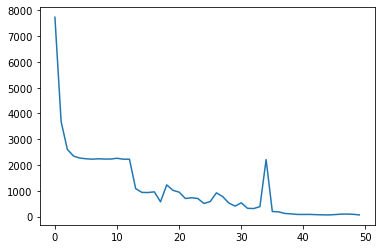

In [11]:
import matplotlib.pyplot as plt
plt.plot(valid_loss)

# Parte 4 - Avaliacao do modelo no conjunto de teste

In [12]:
model.load_state_dict(torch.load("normal_dataset/seg_model_256_50dim_adam"))

<All keys matched successfully>

In [13]:
model.evaluate(test_dataloader, opt='f1')
print("Test set loss:", model.evaluate(test_dataloader, opt='loss'))

100%|██████████| 1268/1268 [00:51<00:00, 24.84it/s]

                  B         I         O
---------  --------  --------  --------
Recall     0.992806  0.984258  0.999725
Precision  0.981043  0.973207  0.99985
F1 score   0.986889  0.978702  0.999787


Test set loss: tensor(287.2744, device='cuda:0')


# Parte 5 - Salvando o modelo

In [14]:
# To save trained pytorch model
# torch.save(model.state_dict(), "seg_model_256")

# # To load trained pytorch model
# loaded_model = LSTM_CRF(embedding_dim=100, word2idx_dict=dic, num_tags=3, hidden_dim=128)
# new_model.load_state_dict(torch.load("seg_model"))